# 05 Python + MR 实现多个数据集的连接（Join）和过滤
---

## 实验目的

基于MapReduce思想，在Hadoop集群上实现多个数据集的连接。

## 实验要求

理解MapReduce编程思想，会用Python编写基于HadoopStreaming的MapReduce多数据集连接（Join）程序，然后将其在本地测试并在Hadoop集群上执行并分析执行过程。

## 实验内容

### 1. 问题描述

这里有三个数据集，分别为**学生表**（student.csv），**成绩表**（score.csv）和**优秀学生表**（top.csv），其中**学生表**的每条记录由***学号（id）***和***姓名（name）***字段组成，**成绩表**的每条记录由***学号（id）***，***科目（course）***和***分数（score）***字段组成，**优秀学生表**的只包含了优秀学生的***姓名（name）***字段。

现在要将**学生表**和**成绩表**按照学号进行连接，生成学生成绩表，新表包含***学号（id）***、***姓名（name）***、***科目（course）***和***分数（score）***。然后，根据***优秀学生表***从***学生成绩表***中过滤出优秀学生的记录并输出。

### 2. 实现原理

给每个数据源加上一个数字标记label，这样hadoop对其排序后同一个字段的数据排在一起并且按照label排好序了，于是直接将相邻相同key的数据合并在一起输出就得到了结果。各个阶段的操作如下：
1. **map**阶段：分别给表1和表2的记录加标记，其实就是多输出一个标记（label）字段，比如来自表1记录的标记字段的值1，来自表2标记字段的值为2
2. **partition**阶段：根据学号key为第一主键，标记字段（label）为第二主键进行排序和分区
3. **reduce**阶段：由于已经按照第一主键、第二主键排好了序，将相邻相同key数据合并输出即可

## 实验步骤

### 1. 准备数据

学生表的数据内容如下：

In [13]:
# 学生表
!cat data/student.csv

id,name
001,Jack
002,Marry
003,Nacy
004,Leion
005,Harry
006,Tomy
007,Sharry
008,ZK
009,HJ
010,MD

In [14]:
# 成绩表
!cat data/score.csv

id,course,score
001,Math,80
001,Python,90
002,Math,82
002,Python,95
003,Math,80
003,Python,95
004,Math,96
004,Python,85
005,Math,78
005,Python,82
006,Math,100
006,Python,100
007,Math,72
007,Python,75
008,Math,100
008,Python,100
009,Math,100
009,Python,100
010,Math,98
010,Python,98

In [15]:
# 优秀学生表
!cat data/top_student.csv

name
ZK
MD
HJ
Tomy

### 2. 编写程序

#### 1）Mapper（student_score_mapper.py）

In [127]:
# 程序代码
!cat input_files/student_score_mapper.py

#!/usr/bin/python
# -*- coding: utf-8 -*-
import sys

def main():
    for line in sys.stdin:
        line = line.strip()
        row = line.split(',')
        sid = row[0]
        if sid == 'sid':
            continue
        if len(row) == 2:
            name = row[1]
            course = '-'
            score = '-'            
        else:
            name = '-'
            course = row[1]
            score = row[2]
        print('\t'.join((sid, course, name, score)))

if __name__ == '__main__':
    main()

#### 2）Reducer（student_score_reducer.py）

In [126]:
# 程序代码
!cat input_files/student_score_reducer.py

#!/usr/bin/python
# -*- coding: utf-8 -*-
import sys

def main():
    sname = None
    for line in sys.stdin:
        line = line.strip()
        row = line.split('\t')
        name = row[2]
        if name == '-':
            row[2] = sname
            print('\t'.join([row[0], row[2], row[1], row[3]]))
        else:
            sname = name

if __name__ == '__main__':
    main()

### 3. 本地测试

In [83]:
# 操作代码
!cat data/student.csv data/score.csv | \
python input_files/student_score_mapper.py

001,Jack
002,Marry
003,Nacy
004,Leion
005,Harry
006,Tomy
007,Sharry
008,ZK
009,HJ
010,MD
001,Math,80
001,Python,90
002,Math,82
002,Python,95
003,Math,80
003,Python,95
004,Math,96
004,Python,85
005,Math,78
005,Python,82
006,Math,100
006,Python,100
007,Math,72
007,Python,75
008,Math,100
008,Python,100
009,Math,100
009,Python,100
010,Math,98
010,Python,98


In [123]:
# 操作代码
!cat data/student.csv data/score.csv | \
python input_files/student_score_mapper.py | \
sort | \
python input_files/student_score_reducer.py

001	Jack	Java	80
001	Jack	Math	80
001	Jack	Python	90
002	Marry	Math	82
002	Marry	Python	95
003	Nacy	Math	80
003	Nacy	Python	95
004	Leion	Math	96
004	Leion	Python	85
005	Harry	Math	78
005	Harry	Python	82
006	Tomy	Math	100
006	Tomy	Python	100
007	Sharry	Math	72
007	Sharry	PHP	69
007	Sharry	Python	75
008	ZK	Math	100
008	ZK	Python	100
009	HJ	Math	100
009	HJ	Python	100
010	MD	Math	98
010	MD	Python	98


### 4. 集群运行

#### 1）上传数据文件到HDFS

In [129]:
# 操作代码
!docker cp ./data/student.csv master:/root/

In [130]:
!docker cp ./data/score.csv master:/root/

In [131]:
!docker cp input_files/student_score_mapper.py master:/root/

In [132]:
!docker cp input_files/student_score_reducer.py master:/root/

In [133]:
!docker exec master \
hadoop fs -put /root/student.csv /input/

In [134]:
!docker exec master \
hadoop fs -put /root/score.csv /input/

#### 2）设置Streaming参数并执行

In [151]:
# 操作代码
!docker exec master \
hadoop fs -rm -f -r /output/student_score
!docker exec master \
hadoop jar /usr/hadoop-2.8.3/share/hadoop/tools/lib/hadoop-streaming-2.8.3.jar \
-D stream.num.map.output.key.fields=3 \
-D num.key.fields.for.partition=1 \
-D mapred.map.tasks=10 \
-D mapred.reduce.tasks=1 \
-D mapred.job.name="Student_Score_Join" \
-partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
-input /input/student.csv \
-input /input/score.csv \
-output /output/student_score \
-mapper /root/student_score_mapper.py \
-reducer /root/student_score_reducer.py \
-file /root/student_score_mapper.py \
-file /root/student_score_reducer.py

19/08/14 11:10:54 INFO Configuration.deprecation: io.bytes.per.checksum is deprecated. Instead, use dfs.bytes-per-checksum
Deleted /output/student_score
19/08/14 11:10:56 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [/root/student_score_mapper.py, /root/student_score_reducer.py] [] /tmp/streamjob7335127436191596496.jar tmpDir=null
19/08/14 11:10:57 INFO Configuration.deprecation: session.id is deprecated. Instead, use dfs.metrics.session-id
19/08/14 11:10:57 INFO jvm.JvmMetrics: Initializing JVM Metrics with processName=JobTracker, sessionId=
19/08/14 11:10:58 INFO jvm.JvmMetrics: Cannot initialize JVM Metrics with processName=JobTracker, sessionId= - already initialized
19/08/14 11:10:58 INFO mapred.FileInputFormat: Total input files to process : 2
19/08/14 11:10:58 INFO mapreduce.JobSubmitter: number of splits:2
19/08/14 11:10:58 INFO Configuration.deprecation: mapred.reduce.tasks is deprecated. Instead, use mapreduce.

#### 3）查看结果

In [152]:
# 操作代码
!docker exec master \
hadoop fs -ls /output/student_score/

Found 2 items
-rw-r--r--   1 root root          0 2019-08-14 11:11 /output/student_score/_SUCCESS
-rw-r--r--   1 root root        399 2019-08-14 11:11 /output/student_score/part-00000


In [153]:
!docker exec master \
hadoop fs -cat /output/student_score/part-00000

001	Jack	Java	80
001	Jack	Math	80
001	Jack	Python	90
002	Marry	Math	82
002	Marry	Python	95
003	Nacy	Math	80
003	Nacy	Python	95
004	Leion	Math	96
004	Leion	Python	85
005	Harry	Math	78
005	Harry	Python	82
006	Tomy	Math	100
006	Tomy	Python	100
007	Sharry	Math	72
007	Sharry	PHP	69
007	Sharry	Python	75
008	ZK	Math	100
008	ZK	Python	100
009	HJ	Math	100
009	HJ	Python	100
010	MD	Math	98
010	MD	Python	98


### 5. 离线分析

#### 1）下载数据到本地

In [155]:
!docker exec master \
hadoop fs -get /output/student_score/part-00000 \
/root/student_score_result.txt

In [156]:
!docker cp master:/root/student_score_result.txt ./data

In [180]:
!echo 'id\tname\tcourse\tscore' > ./data/student_score.csv

In [181]:
!cat data/student_score_result.txt >> ./data/student_score.csv

#### 2）处理数据

In [194]:
import pandas as pd
df = pd.read_csv('data/student_score.csv', sep='\t')
g = df.groupby('id')
r = g.sum()

#### 3）可视化

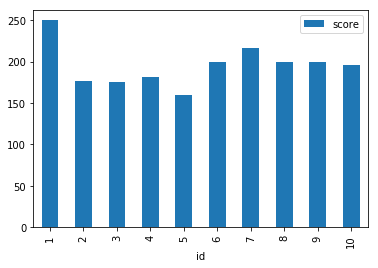

In [195]:
# 程序代码
r.plot(kind = 'bar')

## 实验总结

In [197]:
!pip list

Package                            Version 
---------------------------------- --------
alabaster                          0.7.12  
anaconda-client                    1.7.2   
anaconda-navigator                 1.9.7   
anaconda-project                   0.8.2   
appnope                            0.1.0   
appscript                          1.0.1   
asn1crypto                         0.24.0  
astroid                            2.2.5   
astropy                            3.1.2   
atomicwrites                       1.3.0   
attrs                              19.1.0  
Automat                            0.7.0   
Babel                              2.6.0   
backcall                           0.1.0   
backports.os                       0.1.1   
backports.shutil-get-terminal-size 1.0.0   
beautifulsoup4                     4.7.1   
bitarray                           0.8.3   
bkcharts                           0.2     
bleach                             3.1.0   
bokeh                           

### 1. 过程分析

--- 文字内容 ---

### 2. 心得体会

--- 文字内容 ---